In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
df_1 = pd.read_csv(r"C:\Users\may\Desktop\dataset\CEAS_08.csv")
df_2 = pd.read_csv(r"C:\Users\may\Desktop\dataset/data.csv")
df_3 = pd.read_csv(r"C:\Users\may\Desktop\dataset/balanced.csv")

# Extract relevant features and target
df_1 = df_1[['sender', 'subject', 'body', 'label', 'urls']]
df_2 = df_2[['Email Text', 'Email Type']]
df_3 = df_3[['body', 'class']]
df_2 = df_2.rename(columns={'Email Text': 'body', 'Email Type': 'label'})
df_3 = df_3.rename(columns={'class': 'label'})

# Convert Email Type to boolean
df_2['label'] = df_2['label'].map({'Safe Email': 0, 'Phishing Email': 1})

In [3]:
# Remove empty body row
df_1 = df_1[df_1['body'].str.strip() != ""] # Remove both empty strings and strings with only spaces
df_1 = df_1.dropna(subset=['body']) # Remove rows that is NaN

# Remove empty subject row
df_1 = df_1.dropna(subset=['subject']) # Remove rows that is NaN

# Remove empty label row
df_1 = df_1.dropna(subset=['label']) # Remove rows that is NaN

# Remove empty body row
df_2 = df_2[df_2['body'].str.strip() != ""] # Remove both empty strings and strings with only spaces
df_2 = df_2.dropna(subset=['body']) # Remove rows that is NaN

# Remove empty body row
df_3 = df_3[df_3['body'].str.strip() != ""] # Remove both empty strings and strings with only spaces
df_3 = df_3.dropna(subset=['body']) # Remove rows that is NaN

# Remove empty subject row
df_3 = df_3.dropna(subset=['label']) # Remove rows that is NaN


# Add missing columns to df_2 to match new_df structure
df_2['sender'] = ''
df_2['subject'] = ''  # Empty subject for new dataset

# Add missing columns to df_3 to match new_df structure
df_3['sender'] = ''
df_3['subject'] = ''  # Empty subject for new dataset


# Combine both datasets
df_1 = pd.concat([df_1, df_2, df_3], ignore_index=True)

# Remove rows where label is not 0 or 1
df_1 = df_1[df_1['label'].isin([0, 1])]
# Remove empty label row
df_1 = df_1.dropna(subset=['label']) # Remove rows that is Na

In [4]:
# Text Preprocessing Function
nltk.download('stopwords') # Words like "the", "is", "in", "and", "to"
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to C:\Users\may/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def clean_text(text):
    if not isinstance(text, str):  # Check if the text is not a string
        text = str(text)  # Convert non-string to string
    #text = text.lower()  # Convert to lowercase
    #text = re.sub(r'\W', ' ', text)  # Remove special characters
    #text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

df_1['cleaned_text_subject'] = df_1['subject'].apply(clean_text)
df_1['cleaned_text_body'] = df_1['body'].apply(clean_text)



In [6]:
# Encode 'sender' using Label Encoding
label_encoder = LabelEncoder()
df_1['sender_encoded'] = label_encoder.fit_transform(df_1['sender'])


In [7]:
# Process 'subject' and 'body' using TF-IDF
tfidf_subject = TfidfVectorizer()
tfidf_body = TfidfVectorizer()

In [8]:
X_subject = tfidf_subject.fit_transform(df_1['cleaned_text_subject'])
X_body = tfidf_body.fit_transform(df_1['cleaned_text_body'])
X_sender = df_1['sender_encoded'].values.reshape(-1, 1)

# Combine all features
X_combined = hstack((X_sender, X_subject, X_body))

# Target variable
y = df_1['label']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Train Logistic Regression for sender
log_reg = LogisticRegression()
log_reg.fit(X_train[:, 0], y_train)

# Train Naive Bayes for subject
nb_subject = MultinomialNB()
nb_subject.fit(X_train[:, 1:X_subject.shape[1] + 1], y_train)

# Train Naive Bayes for body
nb_body = MultinomialNB()
nb_body.fit(X_train[:, X_subject.shape[1] + 1:], y_train)

# Predictions
y_pred_sender = log_reg.predict(X_test[:, 0])
y_pred_subject = nb_subject.predict(X_test[:, 1:X_subject.shape[1] + 1])
y_pred_body = nb_body.predict(X_test[:, X_subject.shape[1] + 1:])

# Final prediction using majority voting
y_pred_final = (y_pred_sender + y_pred_subject + y_pred_body) >= 2  # Majority voting

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred_final))
print("Classification Report:\n", classification_report(y_test, y_pred_final))

Accuracy: 0.9560598744567842
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96      6088
           1       0.98      0.93      0.96      6338

    accuracy                           0.96     12426
   macro avg       0.96      0.96      0.96     12426
weighted avg       0.96      0.96      0.96     12426



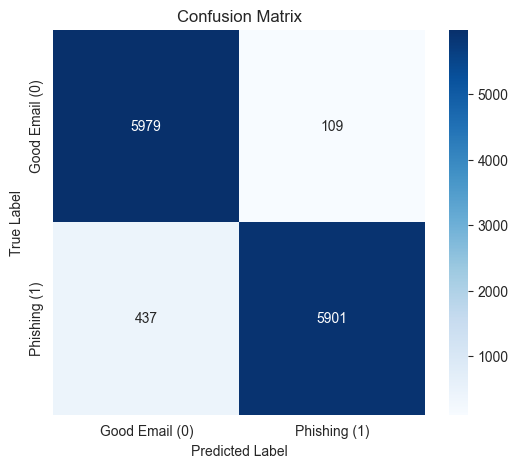

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Good Email (0)', 'Phishing (1)'], yticklabels=['Good Email (0)', 'Phishing (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



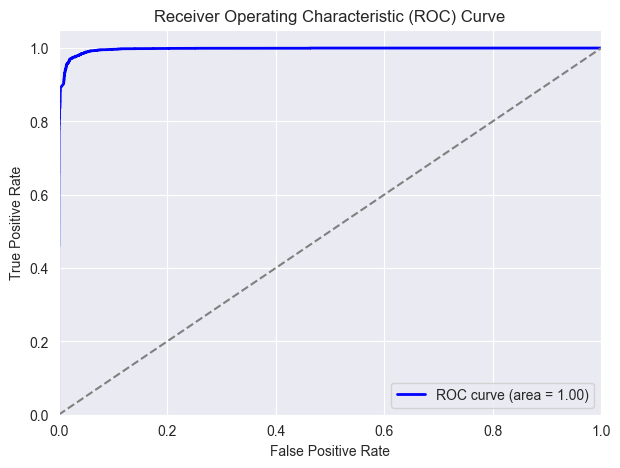

In [10]:
# ROC Curve
y_pred_proba = (log_reg.predict_proba(X_test[:, 0])[:, 1] +
                nb_subject.predict_proba(X_test[:, 1:X_subject.shape[1] + 1])[:, 1] +
                nb_body.predict_proba(X_test[:, X_subject.shape[1] + 1:])[:, 1]) / 3  # Average probability

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()